In [1]:
!hostname
!python -c "import jax; print(jax.default_backend(), jax.devices())"
# import jax; print(jax.__file__)

feynmangpu04.cluster.local


gpu [cuda(id=0)]


In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.95' # jax preallocate GPU (default 75%)
from sys import getsizeof

import matplotlib.pyplot as plt
import numpy as np
from getdist import plots, MCSamples

import jax
from jax import random
import jax.numpy as jnp
import jax_cosmo as jc
# import astropy.units as u

import numpyro
import numpyro.distributions as dist
from numpyro.handlers import seed, condition, trace

from jax.experimental.ode import odeint
from jaxpm.pm import lpt, make_ode_fn
from jaxpm.kernels import fftk
# import haiku as hk

from jaxpm.painting import cic_paint, cic_read
from jaxpm.utils import gaussian_smoothing, power_spectrum

# import diffrax
# from diffrax import diffeqsolve, ODETerm, Dopri5, LeapfrogMidpoint, PIDController, SaveAt


## Power spectrums

In [3]:
def linear_pk_interp(cosmology, scale_factor=1, n_interp=256):
  """
  Return a light emulation of the linear matter power spectrum
  """
  k = jnp.logspace(-4, 1, n_interp)
  pk = jc.power.linear_matter_power(cosmology, k, a=scale_factor)
  pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)
  return pk_fn

def linear_field(mesh_size, box_size, pk):
  """
  Generate initial conditions.
  """
  kvec = fftk(mesh_size)
  kmesh = sum((kk / box_size[i] * mesh_size[i])**2 for i, kk in enumerate(kvec))**0.5
  pkmesh = pk(kmesh) * (mesh_size[0] * mesh_size[1] * mesh_size[2]) / (box_size[0] * box_size[1] * box_size[2])

  field = numpyro.sample(
      'init_mesh_base',
      dist.Normal(jnp.zeros(mesh_size), jnp.ones(mesh_size)))

  field = jnp.fft.rfftn(field) * pkmesh**0.5
  field = jnp.fft.irfftn(field)
  return field

In [6]:
# Mesh and box parameters
box_lengths = 1000 # 100
mesh_lengths = 64 # 64
box_size = np.array([box_lengths, box_lengths, box_lengths])  # In Mpc/h
mesh_size = np.array([mesh_lengths, mesh_lengths, mesh_lengths])

k_nyquist = 2 * jnp.pi * jnp.min(mesh_size / box_size) / 2 # two pi factor because of Fourier transform definition
delta_k = 2 * jnp.pi * jnp.min(1 / box_size)
print(f"{k_nyquist=:.5f} h/Mpc, {delta_k=:.5f} h/Mpc")

# Choose a cosmology
Omega_c, sigma8 = 0.25, 0.8
cosmology = jc.Planck15(Omega_c=Omega_c, sigma8=sigma8)
scale_factor = 0.1

# Sample initial conditions and compute power spectrum
pk_lin_init = linear_pk_interp(cosmology)
init_mesh = linear_field(mesh_size, box_size, pk_lin_init, rng_key=jax.random.PRNGKey(0))
pk_init = power_spectrum(init_mesh, kmin=0.001, dk=0.01, boxsize=box_size)

# Create particles and apply initial displacement
particles_pos = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_size]),axis=-1).reshape([-1,3])

cosmology._workspace = {}  # FIXME: this a temporary fix
dx, p, f = lpt(cosmology, init_mesh, particles_pos, scale_factor)
# NOTE: lpt supposes mesh follows linear pk at scale factor a=1, then correct by growth factor to get mesh at wanted scale factor, then compute forces.
particles_pos = particles_pos + dx

# Paint mesh and compute lpt power spectrum
lpt_mesh = cic_paint(jnp.zeros(mesh_size), particles_pos)
pk_lpt = power_spectrum(lpt_mesh, kmin=0.001, dk=0.01, boxsize=box_size) # TODO correct for CIC
pk_lin_lpt = linear_pk_interp(cosmology, scale_factor)

k_nyquist=0.20106 h/Mpc, delta_k=0.00628 h/Mpc


/feynman/home/dphp/hs276503/.conda/envs/montecosmo/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
/feynman/home/dphp/hs276503/.conda/envs/montecosmo/lib/python3.12/site-packages/jax/_src/lax/lax.py:513: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


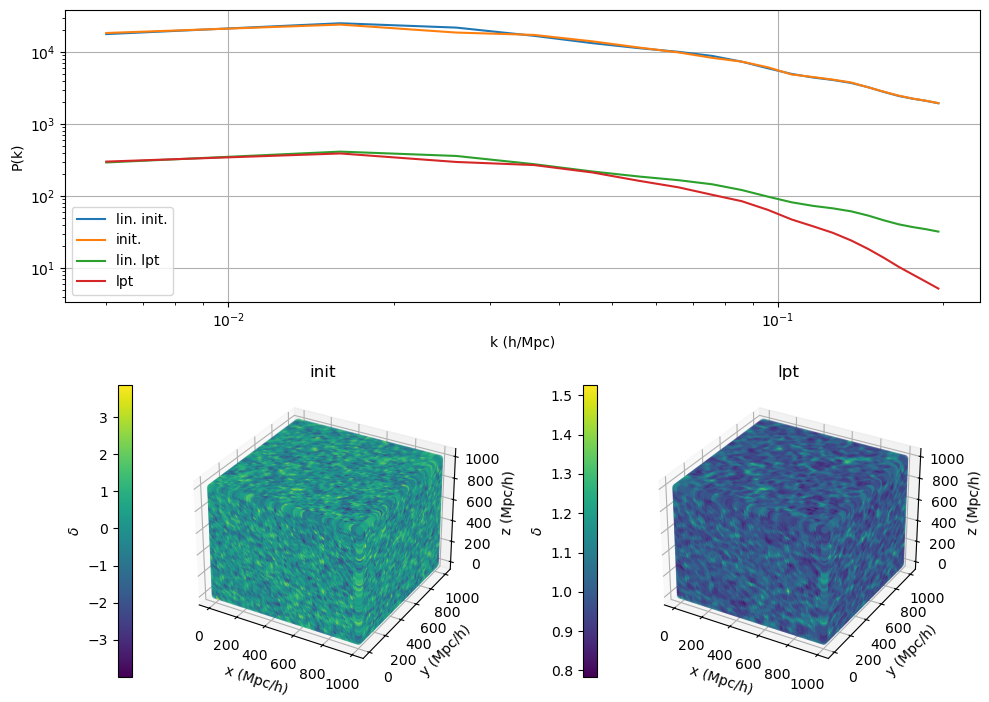

In [7]:
%matplotlib inline
plt.figure(figsize=(10,7))
plt.subplot(211)
plt.loglog(pk_init[0], pk_lin_init(pk_init[0]), label="lin. init.")
plt.loglog(pk_init[0], pk_init[1], label="init.")
plt.loglog(pk_init[0], pk_lin_lpt(pk_init[0]), label="lin. lpt")
plt.loglog(pk_lpt[0], pk_lpt[1], label="lpt")
plt.grid(), plt.legend(), plt.xlabel("k (h/Mpc)"), plt.ylabel("P(k)")

# xx, yy, zz = np.indices(init_mesh.shape) # to get indices
xx, yy, zz = np.mgrid[[slice(0,box_length,init_mesh.shape[i]*1j) 
                       for i, box_length in enumerate(box_size)]] # to get distances
init_color = init_mesh.flatten()
lpt_color = lpt_mesh.flatten()
cmap = plt.colormaps['viridis']

ax3D = plt.subplot(223, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=init_color, cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"$\delta$")
plt.title("init")

ax3D = plt.subplot(224, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=lpt_color, cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"$\delta$")
plt.title("lpt")

plt.tight_layout(), plt.show();

## Inference

In [14]:
def forward_model(box_size, mesh_size, lpt_mesh=None):
  """
  Numpyro forward model.
  """
  # Sample cosmology
  Omega_c_base = numpyro.sample('Omega_c_base', dist.TruncatedNormal(0.,1, low=-1))
  sigma8_base = numpyro.sample('sigma8_base', dist.Normal(0., 1.))
  Omega_c = numpyro.deterministic("Omega_c", Omega_c_base * 0.2 + 0.25)
  sigma8 = numpyro.deterministic("sigma8", sigma8_base * 0.14 + 0.831)

  cosmology = jc.Planck15(Omega_c=Omega_c, sigma8=sigma8)
  # cosmology = numpyro.deterministic("cosmology", cosmology)

  # Sample initial conditions
  pk_fn = linear_pk_interp(cosmology, n_interp=128)
  init_mesh = linear_field(mesh_size, box_size, pk_fn)
  init_mesh = numpyro.deterministic("init_mesh", init_mesh)

  # Create particles
  particles_pos = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_size]),axis=-1).reshape([-1,3])
  
  # Initial displacement
  cosmology._workspace = {}  # FIX ME: this a temporary fix
  dx, p, f = lpt(cosmology, init_mesh, particles_pos, 0.1)
  particles_pos = particles_pos + dx

  lpt_mesh = cic_paint(jnp.zeros(mesh_size), particles_pos)
  lpt_mesh = numpyro.deterministic("lpt_mesh", lpt_mesh)
  # return lpt_mesh

/feynman/home/dphp/hs276503/.conda/envs/montecosmo/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


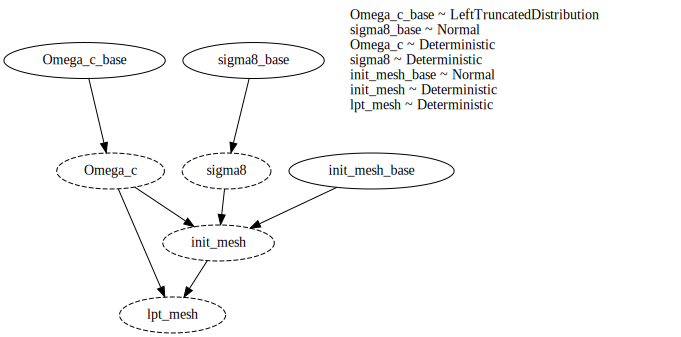

In [15]:
# Mesh and box parameters
box_lengths = 1000 # 100
mesh_lengths = 64 # 64
box_size = np.array([box_lengths, box_lengths, box_lengths])  # In Mpc/h
mesh_size = np.array([mesh_lengths, mesh_lengths, mesh_lengths])

numpyro.render_model(
    model=forward_model,
    model_args=(box_size, mesh_size, ),
    render_distributions=True,
    render_params=True,)

In [6]:
forward_model_jit = jax.jit(seed(forward_model, random.PRNGKey(42)))
forward_model_jit(box_size, mesh_size)

2023-11-07 11:11:37.723293: W external/xla/xla/service/gpu/nvptx_compiler.cc:673] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/feynman/home/dphp/hs276503/.conda/envs/montecosmo/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


ValueError: n should be an integer

In [16]:
fiducial_model = seed(condition(forward_model, {"Omega_c_base": 0, "sigma_8_base": 0}), rng_seed=0) # remember this is reparamd
fiducial_model_trace = trace(fiducial_model).get_trace(box_size, mesh_size)

init_mesh, lpt_mesh = fiducial_model_trace['lpt_mesh']['value'], fiducial_model_trace['lpt_mesh']['value']

# observed_model = numpyro.handlers.condition(forward_model, {"lpt_mesh": lpt_mesh_obs})
# model_trace = numpyro.handlers.trace(numpyro.handlers.seed(fiducial_model, jax.random.PRNGKey(42))).get_trace()

/feynman/home/dphp/hs276503/.conda/envs/montecosmo/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


In [17]:
nuts_kernel = numpyro.infer.NUTS(
        model=forward_model,)

mcmc = numpyro.infer.MCMC(
       nuts_kernel,
       num_warmup=500,
       num_samples=1000,
       # chain_method="parallel", num_chains=8,
       # thinning=2,
       progress_bar=True)

mcmc.run(jax.random.PRNGKey(0), box_size, mesh_size, lpt_mesh=lpt_mesh)
res = mcmc.get_samples()
np.save("./to_del_samples", res)

  0%|          | 0/1500 [00:00<?, ?it/s]/feynman/home/dphp/hs276503/.conda/envs/montecosmo/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
sample: 100%|██████████| 1500/1500 [00:52<00:00, 28.31it/s, 63 steps of size 7.55e-02. acc. prob=0.81]
/feynman/home/dphp/hs276503/.conda/envs/montecosmo/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell enviro


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_c      0.31      0.16      0.29      0.05      0.53    826.05      1.00
    sigma8      0.83      0.13      0.83      0.59      1.02   2196.55      1.00

Removed no burn in


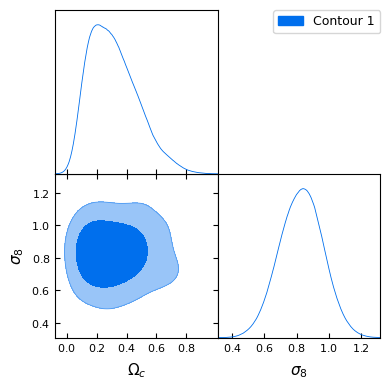

In [18]:
names = ['Omega_c', 'sigma8']
labels = [r'\Omega_c', r'\sigma_8']
samples = np.array([res[key] for key in names]).T
numpyro.diagnostics.print_summary(dict((key, res[key][None]) for key in names) )
samples2 = MCSamples(samples=samples, names=names, labels=labels)
%matplotlib inline
g = plots.get_subplot_plotter()
g.triangle_plot(samples2, filled=True, legend_labels = ['Contour 1'])

## Numpyro tests 

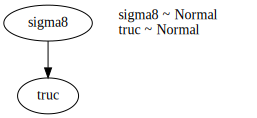

In [92]:
def forward_test():
    sigma8 = numpyro.sample('sigma8', dist.Normal(0, 1))
    sigma16 = 2*sigma8
    truc = numpyro.sample('truc', dist.Normal(sigma16, 1))  
    return truc

numpyro.render_model(
    model=forward_test,
    render_distributions=True,
    render_params=True,)

In [93]:
f_model = numpyro.handlers.seed(forward_test, random.PRNGKey(42))
f_model()

Array(2.5394685, dtype=float32)

In [94]:
forward_test()

AssertionError: 